# TP 1: Analisis Exploratorio
### Arrancando con Jupyter

In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv')
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv')
vistas = pd.read_csv('../data/fiuba_3_vistas.csv')
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv')
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')
avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv')

# Ajustes en los archivos antes de procesar

In [4]:
# Recorto datos innecesarios de avisos_detalles
avisos_detalles.drop('idpais', axis=1, inplace=True)

# Y convierto a categoricos otros datos.
avisos_detalles.nombre_zona = avisos_detalles.nombre_zona.astype('category')
avisos_detalles.ciudad = avisos_detalles.ciudad.astype('category')
avisos_detalles.tipo_de_trabajo = avisos_detalles.tipo_de_trabajo.astype('category')
avisos_detalles.nivel_laboral = avisos_detalles.nivel_laboral.astype('category')
avisos_detalles.nombre_area = avisos_detalles.nombre_area.astype('category')

In [5]:
# Cambio a tipos categoricos las dos columnas de datos.
post_educacion.nombre = post_educacion.nombre.astype('category')
post_educacion.estado = post_educacion.estado.astype('category')

In [6]:
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.sexo = post_gen_edad.sexo.astype('category')
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

In [8]:
# Cambiar el tipo de dato de la fecha de postulacion.
postulaciones['fechapostulacion'] = postulaciones['fechapostulacion'].apply(pd.to_datetime)

In [26]:
# Calculo el uso de memoria previamente para comparar despues.
# [DATAFRAME].memory_usage(deep=True)

In [10]:
# Verifico cuanto cambio el consumo de memoria.
# [DATAFRAME].memory_usage(deep=True)

# Empieza el analisis

In [11]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = [{'nombre': 'Otro', 'estado': 'Abandonado',    'valor_educacion': 1    },
    {'nombre': 'Otro',                  'estado': 'En Curso',    'valor_educacion': 2    },
    {'nombre': 'Otro',                  'estado': 'Graduado',    'valor_educacion': 3    },
    {'nombre': 'Secundario',            'estado': 'Abandonado',    'valor_educacion': 4    },
    {'nombre': 'Secundario',            'estado': 'En Curso',    'valor_educacion': 5    },
    {'nombre': 'Secundario',        'estado': 'Graduado',    'valor_educacion': 6    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Abandonado',    'valor_educacion': 7    },
    {'nombre': 'Universitario',     'estado': 'Abandonado',    'valor_educacion': 8    },
    {'nombre': 'Terciario/Técnico', 'estado': 'En Curso',    'valor_educacion': 9    },
    {'nombre': 'Universitario',     'estado': 'En Curso',    'valor_educacion': 10    },
    {'nombre': 'Terciario/Técnico', 'estado': 'Graduado',    'valor_educacion': 11    },
    {'nombre': 'Universitario',     'estado': 'Graduado',    'valor_educacion': 12    },
    {'nombre': 'Posgrado',          'estado': 'Abandonado',    'valor_educacion': 13    },
    {'nombre': 'Master',            'estado': 'Abandonado',    'valor_educacion': 14    },
    {'nombre': 'Posgrado',          'estado': 'En Curso',    'valor_educacion': 15    },
    {'nombre': 'Master',            'estado': 'En Curso',    'valor_educacion': 16    },
    {'nombre': 'Posgrado',          'estado': 'Graduado',    'valor_educacion': 17    },
    {'nombre': 'Master',            'estado': 'Graduado',    'valor_educacion': 18    },
    {'nombre': 'Doctorado',         'estado': 'Abandonado',    'valor_educacion': 19    },
    {'nombre': 'Doctorado',         'estado': 'En Curso',    'valor_educacion': 20    },
    {'nombre': 'Doctorado',         'estado': 'Graduado',    'valor_educacion': 21 }]
valores_educacion = pd.DataFrame(valores_educacion)

# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [12]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion,  how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [13]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()

# Controlo cuantas lineas me devolvio.
# max_post_educacion.count()

In [14]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], \
                          right_on = ['idpostulante','valor_educacion'])

post_educacion.count()

idpostulante       188752
nombre             188752
estado             188752
valor_educacion    188752
dtype: int64

In [15]:
post_educacion.head()

,idpostulante,nombre,estado,valor_educacion
0,NdJl,Posgrado,En Curso,15
1,axaPJ,Posgrado,En Curso,15
2,Z48mz,Posgrado,En Curso,15
3,a4zEZ,Posgrado,En Curso,15
4,6AWqO,Posgrado,En Curso,15


In [16]:
post_educacion['resumen'] = post_educacion['nombre'] + ' ' + post_educacion["estado"]
post_educacion = post_educacion[['idpostulante', 'valor_educacion', 'resumen']]
post_educacion.head()

,idpostulante,valor_educacion,resumen
0,NdJl,15,Posgrado En Curso
1,axaPJ,15,Posgrado En Curso
2,Z48mz,15,Posgrado En Curso
3,a4zEZ,15,Posgrado En Curso
4,6AWqO,15,Posgrado En Curso


In [17]:
post_educacion_graph = post_educacion.groupby(['valor_educacion', 'resumen'])['idpostulante'].count().reset_index()
post_educacion_graph.head(22)

,valor_educacion,resumen,idpostulante
0,1,Otro Abandonado,219
1,2,Otro En Curso,186
2,3,Otro Graduado,933
3,4,Secundario Abandonado,2681
4,5,Secundario En Curso,3397
5,6,Secundario Graduado,56333
6,7,Terciario/Técnico Abandonado,3034
7,8,Universitario Abandonado,7122
8,9,Terciario/Técnico En Curso,10690
9,10,Universitario En Curso,41097


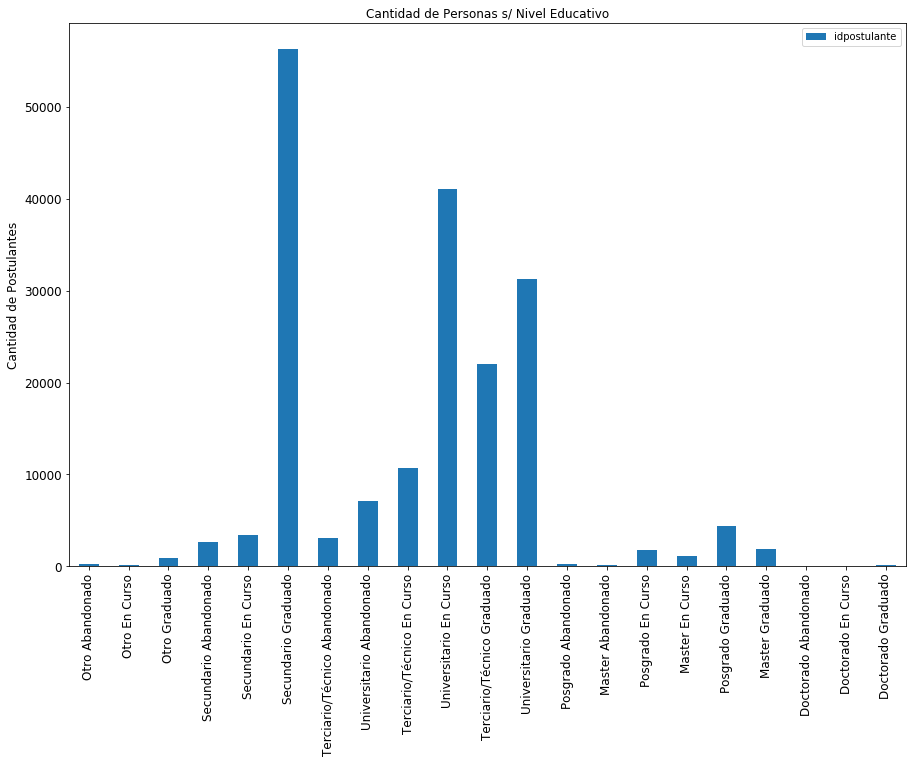

In [18]:
post_educacion_graph = post_educacion_graph[['resumen','idpostulante']].plot(kind='bar', x = 'resumen',                                                           
                                                           title ="Cantidad de Personas s/ Nivel Educativo", 
                                                           figsize=(15, 10), legend=True, fontsize=12)
post_educacion_graph.set_xlabel("", fontsize=12)
post_educacion_graph.set_ylabel("Cantidad de Postulantes", fontsize=12)
plt.show()

In [19]:
post_educacion.head()

,idpostulante,valor_educacion,resumen
0,NdJl,15,Posgrado En Curso
1,axaPJ,15,Posgrado En Curso
2,Z48mz,15,Posgrado En Curso
3,a4zEZ,15,Posgrado En Curso
4,6AWqO,15,Posgrado En Curso


In [20]:
post_educacion.drop('resumen', axis=1, inplace=True)
post_educacion.head()

,idpostulante,valor_educacion
0,NdJl,15
1,axaPJ,15
2,Z48mz,15
3,a4zEZ,15
4,6AWqO,15


In [21]:
postulaciones.head()

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [22]:
postulaciones.head()

,idaviso,idpostulante,fechapostulacion
0,1112257047,NM5M,2018-01-15 16:22:34
1,1111920714,NM5M,2018-02-06 09:04:50
2,1112346945,NM5M,2018-02-22 09:04:47
3,1112345547,NM5M,2018-02-22 09:04:59
4,1112237522,5awk,2018-01-25 18:55:03


In [23]:
avisos_detalles.head()

,idaviso,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa
0,8725750,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR
1,17903700,Enfermeras,<p>Solicitamos para importante cadena de farma...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Salud,Farmacias Central Oeste
2,1000150677,Chofer de taxi,<p>TE GUSTA MANEJAR? QUERES GANAR PLATA HACIEN...,Capital Federal,NaN,Empedrado 2336,Full-time,Senior / Semi-Senior,Transporte,FAMITAX SRL
3,1000610287,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Transporte,Wurth Argentina S.A
4,1000872556,Operarios de Planta - Rubro Electrodomésticos,<p><strong>OPERARIOS DE PLANTA</strong></p><p>...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Producción,ELECTRO OUTLET SRL


In [24]:
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv')
avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv')

In [25]:
postulaciones_avisos = postulaciones.groupby(['valor_educacion', 'resumen'])['idpostulante'].count().reset_index()

KeyError: 'valor_educacion'

In [ ]:
postulaciones_avisos = pd.merge(postulaciones, avisos_detalles,  how='inner', \
                                left_on='idaviso', right_on='idaviso')


In [ ]:
df = postulaciones_avisos.nivel_laboral.isnull().reset_index()
df[df.nivel_laboral == True].count()

In [ ]:
3074206 - 327417

